KeyboardInterrupt: 

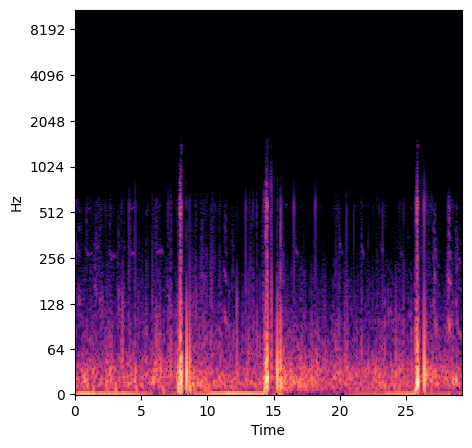

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import numpy as np
import pandas as pd

# Set the directory where you want to save the spectrogram images
output_dir = 'spectrogram_images'
os.makedirs(output_dir, exist_ok=True)

# Load your dataset and CSV file with patient ID and diagnosis
# Replace 'your_data.csv' and 'your_lung_sounds_folder' with your actual data paths
data = pd.read_csv('D:/Assignments Sem-6/Capstone/Data/000_Annotation.csv')
lung_sounds_folder = 'D:/Assignments Sem-6/Capstone/Data/NEW_Data/'

def get_spectogram(audio_file):
    time_series, sample_rate = librosa.load(audio_file)
    stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))
    return librosa.amplitude_to_db(stft, ref=np.max)


# Loop through your dataset
for index, row in data.iterrows():
    patient_id = row['pat_id']
    diagnosis = row['class']
    files = os.listdir(lung_sounds_folder)

    # Construct the path to the lung sound audio file for the current patient
    matching_files = [filename for filename in files if filename.startswith(f'{int(patient_id):03d}') and filename.endswith(".wav")]

    for audio_file_path in matching_files:
        """# Load the audio file using librosa
        y, sr = librosa.load(lung_sounds_folder+audio_file_path)
        data = scale(y)

        # Calculate the spectrogram
        melspec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
        log_melspec = librosa.power_to_db(melspec, ref=np.max)  
        librosa.display.specshow(log_melspec, sr=sr)

        # Create and save the spectrogram image without title, xlabel, and ylabel
        plt.figure(figsize=(8, 6))
        librosa.display.specshow(D, cmap='viridis')

        # Save the spectrogram image to the output directory
        output_image_path = os.path.join(output_dir, audio_file_path+'.png')
        plt.savefig(output_image_path, format='png', bbox_inches='tight')
        plt.close()"""

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))  # Set the figure size to create a square image

        # Plot the first spectrogram
        spectrogram = get_spectogram(lung_sounds_folder + audio_file_path)
        librosa.display.specshow(spectrogram, y_axis='log', x_axis='time', ax=ax)

        output_image_path = os.path.join(output_dir, audio_file_path + '.png')
        plt.savefig(output_image_path, format='png', bbox_inches='tight')
        plt.close()

In [4]:
import os
import numpy as np
import tensorflow as tf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Define a function to load and preprocess the spectrogram images
def load_and_preprocess_images(image_dir):
    image_paths = []
    labels = []

    for image_name in os.listdir(image_dir):
        if image_name.endswith('.png'):
            image_path = os.path.join(image_dir, image_name)
            image_paths.append(image_path)
            diagnosis = data.loc[data['pat_id'] == image_path[0:3], 'class'].values[0]
            labels.append(diagnosis)

    return image_paths, labels

# Load and preprocess spectrogram images
image_dir = '/kaggle/working/spectrogram_images'
image_paths, labels = load_and_preprocess_images(image_dir)

# Encode the labels as numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, encoded_labels, test_size=0.1, random_state=42)

# Function to create and compile the VGG16 model
def create_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # GlobalMaxPooling2D and GlobalAveragePooling2D layers in parallel
    max_pooling = GlobalMaxPooling2D()(base_model.output)
    avg_pooling = GlobalAveragePooling2D()(base_model.output)
    
    # Concatenate both pooling layers
    concatenated = tf.keras.layers.Concatenate()([max_pooling, avg_pooling])
    
    # Dense layer for feature extraction
    dense_layer = tf.keras.layers.Dense(350, activation='relu')(concatenated)
    
    # AFinal output layer for classification
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(dense_layer)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = len(label_encoder.classes_)

# Create the VGG16 model
model = create_vgg16_model(input_shape, num_classes)

# Compile the model
learning_rate = 0.005
max_epochs = 12
validation_freq = 30
batch_size = 32
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess the spectrogram images for training
X_train_images = [tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape[:-1]) for image_path in X_train]
X_train_images = [tf.keras.preprocessing.image.img_to_array(img) for img in X_train_images]
X_train_images = np.array(X_train_images) / 255.0  # Normalize pixel values to [0, 1]
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)

# Train the model
model.fit(X_train_images, y_train_one_hot, epochs=max_epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

# Extract deep features from the fully-connected layer
deep_features_model = Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
deep_features = deep_features_model.predict(X_train_images)

# Apply LDA to the deep features
lda = LinearDiscriminantAnalysis(n_components=64)
X_lda = lda.fit_transform(deep_features, y_train)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/12



KeyboardInterrupt



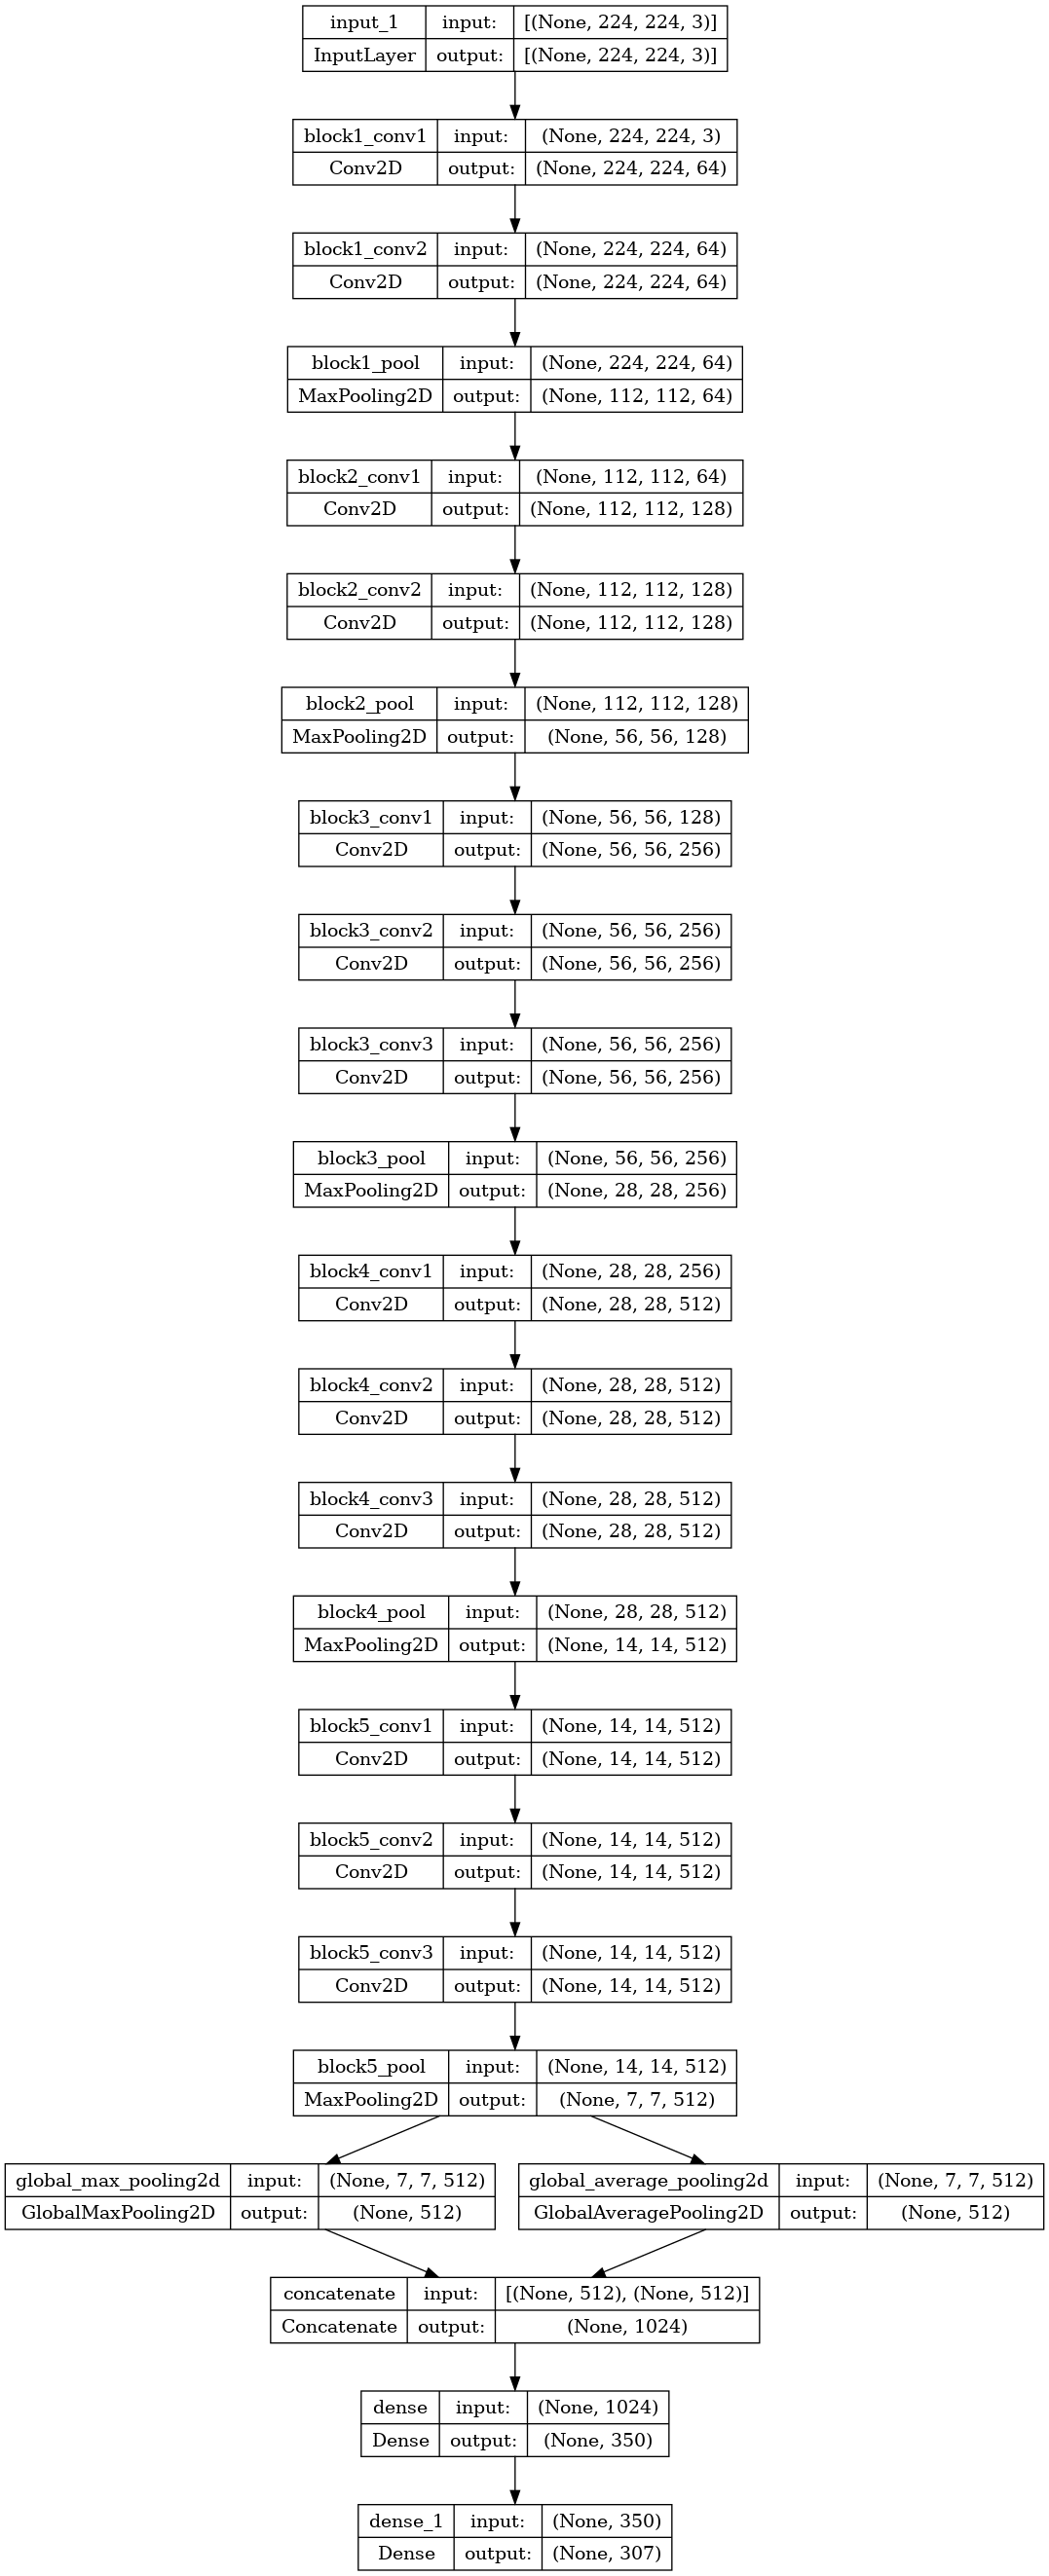

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)